In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Load CSVs (merge real+synthetic)
signal_real = pd.read_csv("./combined-dataset/real-signal-injected.csv", header=None).astype(float)
signal_syn = pd.read_csv("./combined-dataset/synthetic-signal-injected.csv", header=None).astype(float)
noise_real = pd.read_csv("./combined-dataset/real-noise.csv", header=None).astype(float)
noise_syn = pd.read_csv("./combined-dataset/synthetic-noise.csv", header=None).astype(float)

signal_real["label"] = 1
signal_syn["label"] = 1
noise_real["label"] = 0
noise_syn["label"] = 0

# Combine dataset (adjust ratio if needed)
train_data = pd.concat([signal_real, signal_syn, noise_real, noise_syn], axis=0)
train_data = shuffle(train_data, random_state=42)

X = train_data.iloc[:, :-1].values
y = train_data["label"].values.astype(np.float32)

# Normalize based on pure noise only
noise_all = pd.concat([noise_real, noise_syn], axis=0)
scaler = StandardScaler()
scaler.fit(noise_all.iloc[:, :-1])
X = scaler.transform(X)

# Expand for CNN input
X = np.expand_dims(X, axis=-1)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, ReLU,
                                     MaxPooling1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def residual_block(x, filters, kernel_size=8, pool_size=4, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding = 'same')(shortcut)
    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_best_cnn(input_shape=(16384, 1)):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv1D(32, 16, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=4)(x)

    # Residual Blocks
    x = residual_block(x, 64, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 128, 8, pool_size=4, dropout_rate=0.3)
    x = residual_block(x, 256, 4, pool_size=4, dropout_rate=0.4)

    # Global feature aggregation
    x = Conv1D(512, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling1D()(x)

    # Classifier
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_best_cnn()
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
y_pred = model.predict(X_val).ravel()

Epoch 1/50
448/448 [==============================] - 61s 107ms/step - loss: 0.7122 - accuracy: 0.5080 - val_loss: 0.7065 - val_accuracy: 0.5036
Epoch 2/50
448/448 [==============================] - 62s 137ms/step - loss: 0.6965 - accuracy: 0.5096 - val_loss: 0.7453 - val_accuracy: 0.5000
Epoch 3/50
448/448 [==============================] - 62s 138ms/step - loss: 0.6524 - accuracy: 0.5828 - val_loss: 0.6373 - val_accuracy: 0.6030
Epoch 4/50
448/448 [==============================] - 62s 138ms/step - loss: 0.4337 - accuracy: 0.7409 - val_loss: 0.6097 - val_accuracy: 0.7081
Epoch 5/50
448/448 [==============================] - 62s 139ms/step - loss: 0.3909 - accuracy: 0.7633 - val_loss: 0.6065 - val_accuracy: 0.7480
Epoch 6/50
448/448 [==============================] - 62s 138ms/step - loss: 0.3765 - accuracy: 0.7831 - val_loss: 0.4760 - val_accuracy: 0.7732
Epoch 7/50
448/448 [==============================] - 62s 139ms/step - loss: 0.3588 - accuracy: 0.7904 - val_loss: 0.4194 - val_ac

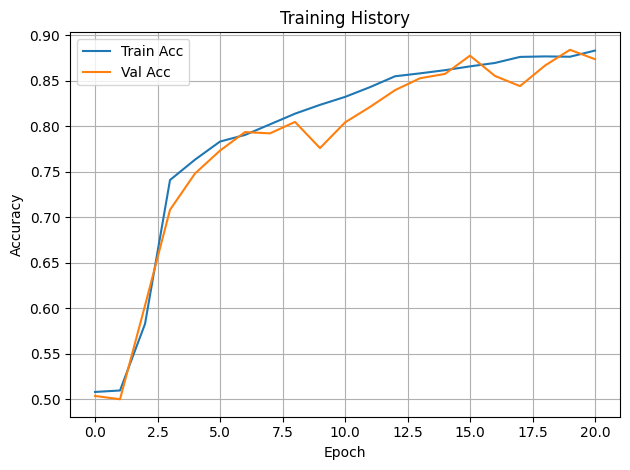

ROC AUC Score: 0.9540584330656091
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      1792
         1.0       0.93      0.82      0.87      1792

    accuracy                           0.88      3584
   macro avg       0.88      0.88      0.88      3584
weighted avg       0.88      0.88      0.88      3584


Confusion Matrix (counts):
[[1676  116]
 [ 323 1469]]

Rates:
  TPR (Recall)      : 0.8198
  FPR               : 0.0647
  TNR (Specificity) : 0.9353
  FNR               : 0.1802


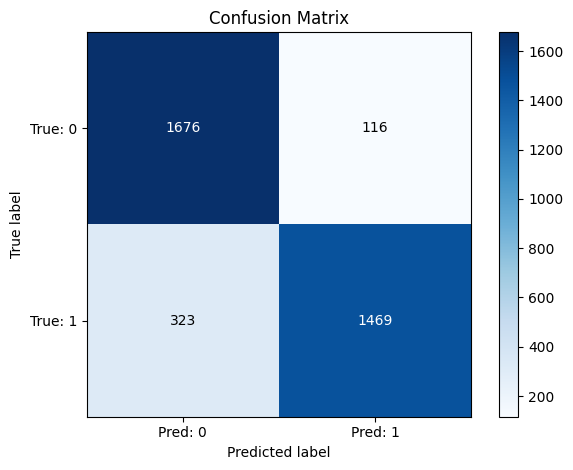

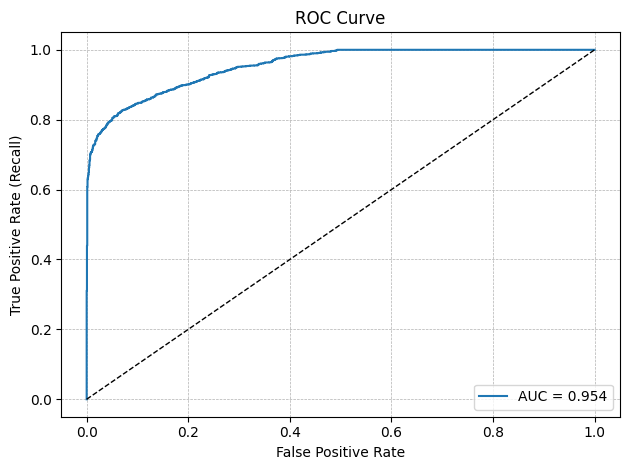

Gini Coefficient: 0.9081
Jaccard Score: 0.7699


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    jaccard_score
)

# Accuracy history plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Core text metrics
print("ROC AUC Score:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

#Confusion matrix + rates
y_pred_labels = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_labels)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix (counts):")
print(cm)

# Rates
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall / Sensitivity
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Specificity
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

print("\nRates:")
print(f"  TPR (Recall)      : {tpr:.4f}")
print(f"  FPR               : {fpr:.4f}")
print(f"  TNR (Specificity) : {tnr:.4f}")
print(f"  FNR               : {fnr:.4f}")

# Confusion matrix heatmap
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Pred: 0", "Pred: 1"])
plt.yticks(ticks, ["True: 0", "True: 1"])

# draw numbers
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

#ROC curve + AUC + Gini
fpr_curve, tpr_curve, _ = roc_curve(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)
gini = 2 * auc_val - 1

plt.figure()
plt.plot(fpr_curve, tpr_curve, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"Gini Coefficient: {gini:.4f}")

#Jaccard + Precision–Recall curve
jac = jaccard_score(y_val, y_pred_labels)
print(f"Jaccard Score: {jac:.4f}")

In [5]:
model.save("final_combined_cnn_model.h5")
np.save("scaler_mean_combined.npy", scaler.mean_)
np.save("scaler_scale_combined.npy", scaler.scale_)